## Analysis of statistics for Yandex.Zen authors

The main goal of my research is to answer two questions: 1) which feature, provided by Yandex.Zen statistics, have a significant impact on Readings; 2) is it possible to use feature from statistics to predict the development of the blog. I assume that the main feature is Reading, since it is reading that affects advertising and revenue (this can change if the main block of advertising moves to the right). Therefore, I am interested in what feature affect the Readings.

All the feature that Yandex.Zen provides can be divided into two categories: the feature that the author can influence (directly and indirectly) and feature that the author does not influence.  

Feature on which the author has an indirect effect:
1) Readings
2) Avg. read time, sec.
3) Comments
4) Subscriptions 
5) Like

Feature that the author directly affects:
1) Characters
2) Number of subheadings
3) Day of the week
4) Header length

Feature that the author does not influence:
1) Views
2) CTR
3) Coverage
4) Days

Thus, we are concerned precisely with the influence on the features on which the author has influence (without Readings). 

Initially, I will conduct a study that does not take into account the distribution over time. Then I study the distribution over time. However, in this latter case, there is still difficulty: the date of publication in Yandex.Zen statistics changes if edits are made. Therefore in 2018 they accumulated near one date when I was doing a lot of editing. Therefore, studying the distribution in time, I will only use data from January 1, 2019.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import calendar
from matplotlib import rcParams
import datetime as dt
from datetime import datetime, timedelta
from bs4 import BeautifulSoup
import requests
from sklearn.cluster import KMeans
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose

### Data preparation

In [2]:
data_1 = pd.read_excel('D:\Data Science\Яндекс Дзен\\zen_stat_2017-12-14_2020-05-18.xls')
data_1.head()

,Дата публикации,Тип публикации,Тип продвижения,Статус промо,Публикация,Ссылка на публикацию,Дочитывания,"Сред. время дочитываний, сек.",Процент дочитывания публикации,Просмотры,"CTR, %",Охват,Комментарии,Подписки после просмотра,"Отметки ""Больше такого"""
0,2020-05-15 07:08:31.855,Статья,Органика,NaN,Верховный суд объяснил как жильцам не платить ...,https://zen.yandex.ru/media/id/5a32286377d0e6a...,1847,149,0.559867,3299,0.044317,75073,3,6,66
1,2020-05-14 09:55:20.214,Статья,Органика,NaN,При Сталине образование в школах и ВУЗах было ...,https://zen.yandex.ru/media/id/5a32286377d0e6a...,2084,74,0.941708,2213,0.043229,48486,144,0,31
2,2020-05-11 17:39:04.883,Статья,Органика,NaN,С 12 мая президент отменил нерабочие дни,https://zen.yandex.ru/media/id/5a32286377d0e6a...,7274,45,0.943450,7710,0.044217,166360,12,0,20
3,2020-05-08 13:31:24.809,Статья,Органика,NaN,Куда выбрасывать крупногабаритный мусор из ква...,https://zen.yandex.ru/media/id/5a32286377d0e6a...,1753,70,0.940451,1864,0.036516,50087,4,0,24
4,2020-05-07 12:11:59.402,Статья,Органика,NaN,Новое в ЖКХ в мае 2020,https://zen.yandex.ru/media/id/5a32286377d0e6a...,62457,91,0.882747,70753,0.103015,498482,125,10,386


In [3]:
data_1 = pd.read_excel('D:\Data Science\Яндекс Дзен\\zen_stat_2017-12-14_2020-05-18.xls')
data_1.set_axis(['Date of publication', 'Publication Type', 'Promotion Type', 'Promo Status','Publication', 'Link to publication', 'Readings', 'Avg. read time, sec.', 'Percentage of reading the publication', 'Views', 'CTR', 'Сoverage', 'Comments','Subscriptions', 'Like'], axis = 'columns', inplace = True)
data_1['Date of publication'] = data_1['Date of publication'].dt.date #we extract only dates, we remove time
data_1['Date of publication'] = pd.to_datetime(data_1['Date of publication'], format='%Y-%m-%d') #we bring to the desired format
data_1 = data_1[['Date of publication', 'Publication', 'Percentage of reading the publication', 'Readings','Avg. read time, sec.','Views', 'CTR', 'Сoverage', 'Comments','Subscriptions', 'Like', 'Link to publication']]
data_1 = data_1.drop_duplicates(subset='Publication') #remove Promo as duplicates

In [4]:
data_1.head()

,Date of publication,Publication,Percentage of reading the publication,Readings,"Avg. read time, sec.",Views,CTR,Сoverage,Comments,Subscriptions,Like,Link to publication
0,2020-05-15,Верховный суд объяснил как жильцам не платить ...,0.559867,1847,149,3299,0.044317,75073,3,6,66,https://zen.yandex.ru/media/id/5a32286377d0e6a...
1,2020-05-14,При Сталине образование в школах и ВУЗах было ...,0.941708,2084,74,2213,0.043229,48486,144,0,31,https://zen.yandex.ru/media/id/5a32286377d0e6a...
2,2020-05-11,С 12 мая президент отменил нерабочие дни,0.943450,7274,45,7710,0.044217,166360,12,0,20,https://zen.yandex.ru/media/id/5a32286377d0e6a...
3,2020-05-08,Куда выбрасывать крупногабаритный мусор из ква...,0.940451,1753,70,1864,0.036516,50087,4,0,24,https://zen.yandex.ru/media/id/5a32286377d0e6a...
4,2020-05-07,Новое в ЖКХ в мае 2020,0.882747,62457,91,70753,0.103015,498482,125,10,386,https://zen.yandex.ru/media/id/5a32286377d0e6a...


#### Enriching data

In [5]:
data_1['Days'] = pd.to_datetime("now", format='%Y-%m-%d') - data_1['Date of publication']
data_1['Days'] = data_1['Days'].dt.days
data_1['CTR'] = data_1['CTR']*100
data_1.set_index('Date of publication', inplace=True)

In [6]:
def count_words(url): #the function returns the number of characters in the text of the blog post
    def get_html(url):
        r=requests.get(url)
        return r.text #returns html code
    a = get_html(url)
    def get_all_text(a):
        soup = BeautifulSoup(a, 'lxml')
        text = soup.find('div', class_='article-render').get_text()
        lenhead = soup.find_all('h3')
        return text
    b = get_all_text(a)
    b = b.replace('.', '. ')
    b = b.replace('.  ', '. ')
    b = b.replace('?', '? ')
    b = b.replace(',', ', ')
    b = b.replace(',  ', ', ')
    count_ = len(b)
    return count_

In [7]:
data_1.head()

,Publication,Percentage of reading the publication,Readings,"Avg. read time, sec.",Views,CTR,Сoverage,Comments,Subscriptions,Like,Link to publication,Days
Date of publication,,,,,,,,,,,,
2020-05-15,Верховный суд объяснил как жильцам не платить ...,0.559867,1847,149,3299,4.431686,75073,3,6,66,https://zen.yandex.ru/media/id/5a32286377d0e6a...,49
2020-05-14,При Сталине образование в школах и ВУЗах было ...,0.941708,2084,74,2213,4.322897,48486,144,0,31,https://zen.yandex.ru/media/id/5a32286377d0e6a...,50
2020-05-11,С 12 мая президент отменил нерабочие дни,0.943450,7274,45,7710,4.421736,166360,12,0,20,https://zen.yandex.ru/media/id/5a32286377d0e6a...,53
2020-05-08,Куда выбрасывать крупногабаритный мусор из ква...,0.940451,1753,70,1864,3.651646,50087,4,0,24,https://zen.yandex.ru/media/id/5a32286377d0e6a...,56
2020-05-07,Новое в ЖКХ в мае 2020,0.882747,62457,91,70753,10.301475,498482,125,10,386,https://zen.yandex.ru/media/id/5a32286377d0e6a...,57


In [8]:
#%%time
#import time
#data_1['Characters'] = data_1['Link to publication'].apply(count_words) 

In [9]:
def count_h3(url): #returns the number of subheadings in the text of the record (indicator of structure)
    def get_html(url):
        r=requests.get(url)
        return r.text #returns html code
    a = get_html(url)
    def get_all_h3(a):
        soup = BeautifulSoup(a, 'lxml')
        head = soup.find_all('h3')
        return head
    h = get_all_h3(a)
    head_ = len(h)
    return head_

In [10]:
#%%time
#import time
#data_1['Number of subheadings'] = data_1['Link to publication'].apply(count_h3) #closed so as not to execute every time

In [11]:
data_1 = data_1.drop('Link to publication', axis=1) 

In [12]:
data_1.to_excel("zen_20_05_18_2.xlsx") 

In [13]:
data = pd.read_excel('D:\Data Science\Яндекс Дзен\\zen_20_05_18_2.xlsx')

In [14]:
data = data.drop(['Percentage of reading the publication'], axis='columns')

In [15]:
data.columns

Index(['Date of publication', 'Publication', 'Readings',
       'Avg. read time, sec.', 'Views', 'CTR', 'Сoverage', 'Comments',
       'Subscriptions', 'Like', 'Days', 'Characters', 'Number of subheadings'],
      dtype='object')

In [16]:
data['Day of the week'] = data['Date of publication'].dt.weekday
data['Header length'] = data.Publication.apply(lambda x: len(x)) 


In [17]:
data.set_index('Date of publication', inplace=True)


### EDA

In [18]:
data.head()

,Publication,Readings,"Avg. read time, sec.",Views,CTR,Сoverage,Comments,Subscriptions,Like,Days,Characters,Number of subheadings,Day of the week,Header length
Date of publication,,,,,,,,,,,,,,
2020-05-15,Верховный суд объяснил как жильцам не платить ...,1847,149,3299,4.431686,75073,3,6,66,13,3452,4,4,82
2020-05-14,При Сталине образование в школах и ВУЗах было ...,2084,74,2213,4.322897,48486,144,0,31,14,1806,2,3,89
2020-05-11,С 12 мая президент отменил нерабочие дни,7274,45,7710,4.421736,166360,12,0,20,17,1474,4,0,40
2020-05-08,Куда выбрасывать крупногабаритный мусор из ква...,1753,70,1864,3.651646,50087,4,0,24,20,2105,2,4,76
2020-05-07,Новое в ЖКХ в мае 2020,62457,91,70753,10.301475,498482,125,10,386,21,1933,3,3,22


In [19]:
data.describe()

,Readings,"Avg. read time, sec.",Views,CTR,Сoverage,Comments,Subscriptions,Like,Days,Characters,Number of subheadings,Day of the week,Header length
count,526.000000,526.000000,526.000000,526.000000,5.260000e+02,526.000000,526.000000,526.000000,526.000000,526.000000,526.000000,526.000000,526.000000
mean,13455.055133,107.733840,17067.899240,3.864616,2.494156e+05,43.285171,8.958175,384.802281,489.568441,2289.806084,0.925856,1.634981,53.849810
std,40287.133831,45.147562,49296.537801,2.158883,5.346960e+05,202.429159,34.027918,1151.692963,195.178839,1411.146880,1.487797,1.930170,15.749415
min,43.000000,26.000000,112.000000,0.300380,5.965000e+03,0.000000,0.000000,5.000000,13.000000,771.000000,0.000000,0.000000,19.000000
25%,1074.250000,76.000000,1403.000000,2.268165,3.676875e+04,0.000000,0.000000,50.250000,428.500000,1616.500000,0.000000,0.000000,43.000000
50%,2883.000000,100.000000,3629.000000,3.395345,8.505200e+04,1.000000,1.000000,146.000000,598.000000,1944.500000,0.000000,1.000000,52.000000
75%,9015.000000,127.000000,11121.500000,4.918829,2.454640e+05,19.000000,3.000000,381.000000,605.000000,2469.750000,1.000000,3.000000,63.000000
max,494351.000000,397.000000,556657.000000,16.506970,5.559069e+06,2848.000000,480.000000,19422.000000,605.000000,20585.000000,8.000000,6.000000,106.000000


In [20]:
data.columns

Index(['Publication', 'Readings', 'Avg. read time, sec.', 'Views', 'CTR',
       'Сoverage', 'Comments', 'Subscriptions', 'Like', 'Days', 'Characters',
       'Number of subheadings', 'Day of the week', 'Header length'],
      dtype='object')

#### Outlier

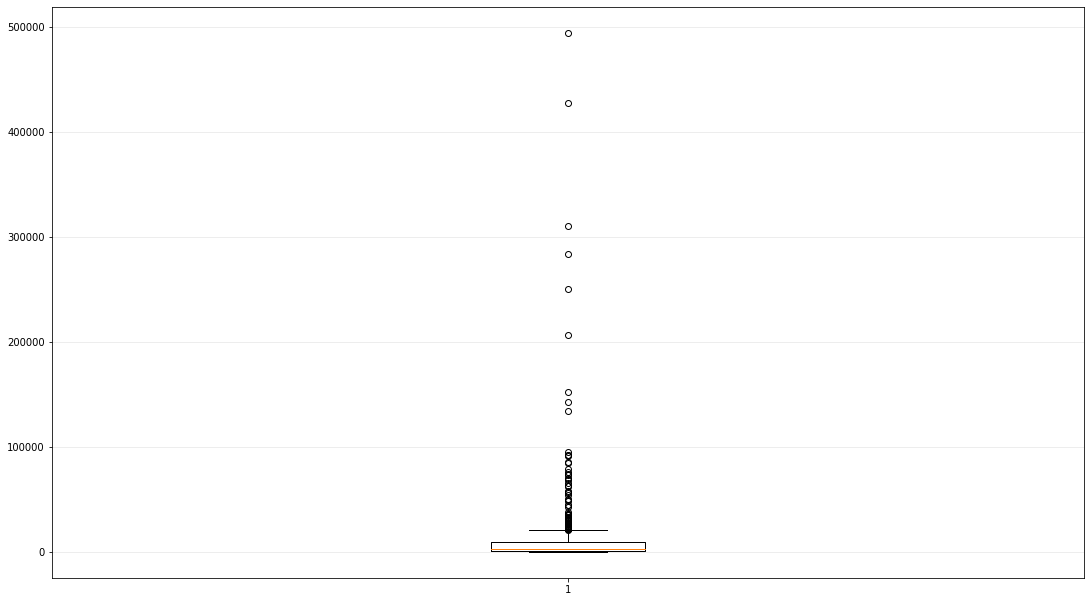

In [21]:
fig, ax = plt.subplots() 
fig.set_size_inches(18.5, 10.5)
ax.boxplot(data['Readings'])
ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', #добавляет сетку по горизонтали
               alpha=0.5)
plt.show()

[21323,
 21511,
 21631,
 21660,
 21963,
 22036,
 22091,
 22215,
 22715,
 23090,
 23261,
 23550,
 23709,
 23813,
 23837,
 24091,
 24523,
 24526,
 25622,
 26160,
 27495,
 27600,
 27746,
 27800,
 28367,
 30425,
 30483,
 31374,
 32163,
 32239,
 32553,
 32942,
 33578,
 34844,
 35282,
 35791,
 36052,
 36561,
 37544,
 42825,
 44580,
 44997,
 48812,
 49300,
 50176,
 54110,
 56514,
 56867,
 57691,
 62457,
 63061,
 63164,
 66035,
 68576,
 69057,
 70733,
 73145,
 74089,
 75647,
 79438,
 84646,
 85499,
 91233,
 92379,
 92479,
 95254,
 134435,
 143080,
 152440,
 206927,
 250516,
 284200,
 310834,
 427816,
 494351]

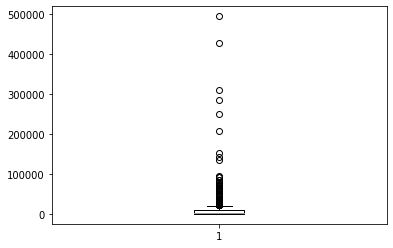

In [22]:
boxplot = plt.boxplot(data['Readings'].values)
outliers = list(boxplot["fliers"][0].get_data()[1])
sorted(outliers)

#### Without Outlier since 2018

In [23]:
df_1 = data[data['Readings'] < 21323]
df = df_1.drop(['Comments', 'Subscriptions'], axis='columns') #remove these signs, because there are no data on them for 2018
df.describe()

,Readings,"Avg. read time, sec.",Views,CTR,Сoverage,Like,Days,Characters,Number of subheadings,Day of the week,Header length
count,451.000000,451.000000,451.000000,451.000000,451.000000,451.000000,451.000000,451.000000,451.000000,451.000000,451.000000
mean,3959.711752,106.328160,5028.751663,3.337065,110255.895787,176.232816,503.239468,2255.523282,0.804878,1.603104,53.283814
std,4497.192271,44.707331,5714.007581,1.550685,116146.377927,190.604154,187.115960,1462.936856,1.362049,1.958432,15.490188
min,43.000000,26.000000,112.000000,0.300380,5965.000000,5.000000,13.000000,771.000000,0.000000,0.000000,19.000000
25%,826.500000,75.000000,1078.000000,2.141641,28661.500000,44.000000,575.000000,1596.000000,0.000000,0.000000,43.000000
50%,2261.000000,99.000000,2854.000000,3.034301,67656.000000,111.000000,599.000000,1917.000000,0.000000,1.000000,52.000000
75%,4867.500000,125.000000,6478.500000,4.297350,141721.000000,236.500000,605.000000,2403.000000,1.000000,3.000000,62.000000
max,20764.000000,397.000000,31257.000000,8.098885,612090.000000,1561.000000,605.000000,20585.000000,8.000000,6.000000,106.000000


<Figure size 432x288 with 0 Axes>

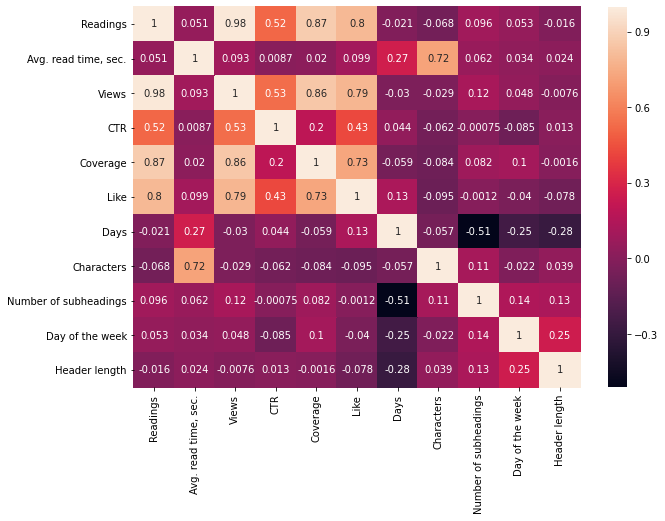

In [24]:
plt.figure()
f, ax = plt.subplots(figsize=(10, 7))
ax = sns.heatmap(df.corr(), annot=True, clip_on=False)

A very high correlation between the Readings and the Views attribute. This means that if the user opened the post, then he will read it. The high correlation between Readings and signs of Coverage, Like. Signs that the author may influence have a medium or low correlation, except for Like. It is important to note that the correlation between Like and Coverage is also high. A weak correlation based on CTR shows that Readings are not affected by either the title, or the design of the card, or its location among other entries in the tape.

slope = 18.894373370412183 readings increase with like increase
intercept = 629.9031267101311 minimum coefficient of like


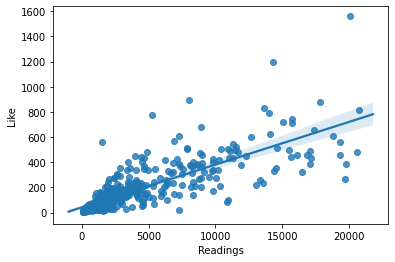

In [25]:
sns.regplot(x='Readings', y='Like', data=df)
a, b = np.polyfit(df['Like'], df['Readings'], 1)
print('slope =', a, 'readings increase with like increase')
print('intercept =', b, 'minimum coefficient of like')

Null hypothesis: The correlation between Like and Readings in samples is greater than or equal to the correlation from heatmap

In [26]:
pear_corr = df['Like'].corr(df['Readings'])
perm_replicates = np.empty(10000)
for i in range(10000):
    perm = np.random.permutation(df['Like'])
    perm_replicates[i] = df['Like'].corr(df['Readings'])
p = np.sum(perm_replicates >= pear_corr)/len(perm_replicates)
print('p-val =', p)

p-val = 1.0


The null hypothesis is confirmed.

#### Without Outlier since 2019

In [27]:
df_1.sort_index(inplace=True) 
df_2019 = df_1.loc['2019-01-01':'2020-05-18'] 

C:\Users\1\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<Figure size 432x288 with 0 Axes>

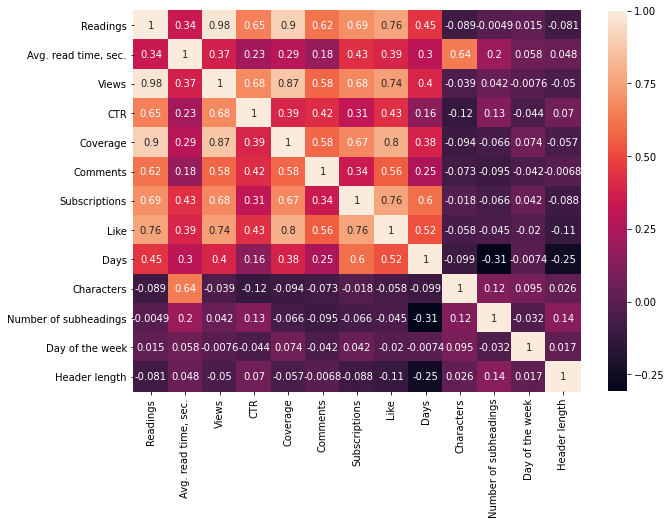

In [28]:
plt.figure()
f, ax = plt.subplots(figsize=(10, 7))
ax = sns.heatmap(df_2019.corr(), annot=True, clip_on=False)

Since 2019, there are data on the characteristics of Comments and Subscriptions. We see that there is a very high correlation between Reading and Viewing. However, signs that the author may influence (Comments, Subscriptions after viewing) have an average correlation and we may not take them into account.  An exception is Like, which has a high correlation. It is important that the Days since publication has a weak correlation with Readings.

#### Outlier since 2018

In [29]:
df_outliner_1 = data[data['Readings'] >=21323] #изучаем выбросы
df_outliner = df_outliner_1.drop(['Comments', 'Subscriptions'], axis='columns') #remove these signs, because there are no data on them for 2018
df_outliner.describe()

,Readings,"Avg. read time, sec.",Views,CTR,Сoverage,Like,Days,Characters,Number of subheadings,Day of the week,Header length
count,75.000000,75.000000,75.000000,75.000000,7.500000e+01,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000
mean,70553.720000,116.186667,89463.306667,7.036961,1.086229e+06,1639.000000,407.360000,2495.960000,1.653333,1.826667,57.253333
std,86822.247803,47.137434,104149.388394,2.558835,1.057622e+06,2707.384391,222.182944,1030.944941,1.948619,1.750470,16.939553
min,21323.000000,45.000000,24604.000000,2.662959,2.480790e+05,144.000000,21.000000,1274.000000,0.000000,0.000000,22.000000
25%,25891.000000,85.500000,34826.000000,5.080969,5.033475e+05,623.500000,130.500000,1804.000000,0.000000,0.000000,44.000000
50%,36561.000000,102.000000,48406.000000,6.819294,7.331190e+05,969.000000,545.000000,2162.000000,1.000000,1.000000,56.000000
75%,71939.000000,134.500000,92043.000000,8.413526,1.146766e+06,1719.500000,598.000000,2812.000000,2.000000,3.000000,70.000000
max,494351.000000,257.000000,556657.000000,16.506970,5.559069e+06,19422.000000,605.000000,5678.000000,8.000000,6.000000,97.000000


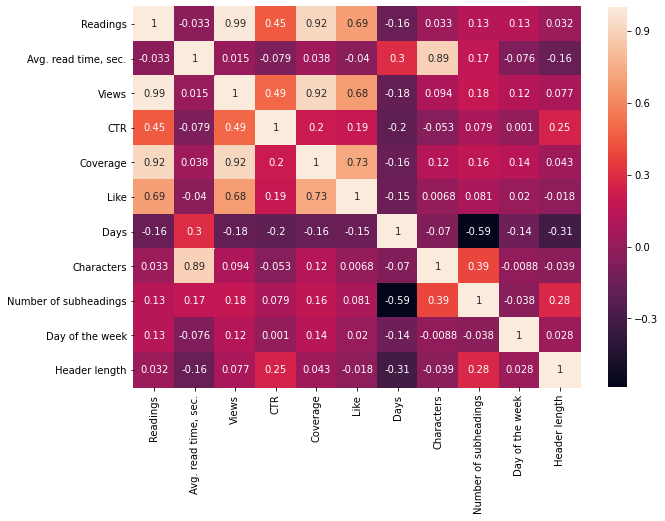

In [30]:
f, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(df_outliner.corr(), annot=True, clip_on=False)

It is interesting here that the correlation with Like decreases to an average correlation (less than 0.7), but the correlation with Coverage increases. CTR correlation decreases to 0.45. The outliers are articles that are trending at the time of publication. The author cannot influence emissions since he does not see trends from statistics. The author can only affect ordinary articles through Like. 

#### Outlier since 2019

In [31]:
pr = data[data['Readings'] >=21323] 
pr.sort_index(inplace=True) 
df_outliner_2019 = pr.loc['2019-01-01':'2020-05-18']
df_outliner_2019.describe()

C:\Users\1\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Readings,"Avg. read time, sec.",Views,CTR,Сoverage,Comments,Subscriptions,Like,Days,Characters,Number of subheadings,Day of the week,Header length
count,36.000000,36.000000,36.000000,36.000000,3.600000e+01,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000
mean,75691.027778,110.833333,98794.305556,7.364556,1.180179e+06,357.361111,70.111111,1914.888889,212.277778,2703.333333,2.611111,2.083333,60.138889
std,93300.820558,48.541882,117246.054156,2.830482,1.162154e+06,598.575029,95.224180,3790.550859,169.161396,1037.385202,1.946099,1.500000,19.600514
min,21323.000000,45.000000,25488.000000,2.662959,2.976520e+05,0.000000,2.000000,144.000000,21.000000,1372.000000,0.000000,0.000000,22.000000
25%,27573.750000,80.000000,36212.000000,5.364751,5.654238e+05,78.250000,13.000000,487.500000,57.750000,1954.750000,1.000000,1.000000,42.750000
50%,36306.500000,97.000000,47001.000000,6.815353,7.294375e+05,138.000000,37.500000,818.000000,127.500000,2465.500000,2.000000,2.000000,63.000000
75%,71336.000000,133.500000,99020.500000,9.301705,1.166342e+06,401.250000,81.000000,1849.750000,394.000000,3257.000000,4.000000,3.000000,76.000000
max,427816.000000,235.000000,483303.000000,16.506970,5.383307e+06,2848.000000,480.000000,19422.000000,510.000000,5678.000000,8.000000,5.000000,97.000000


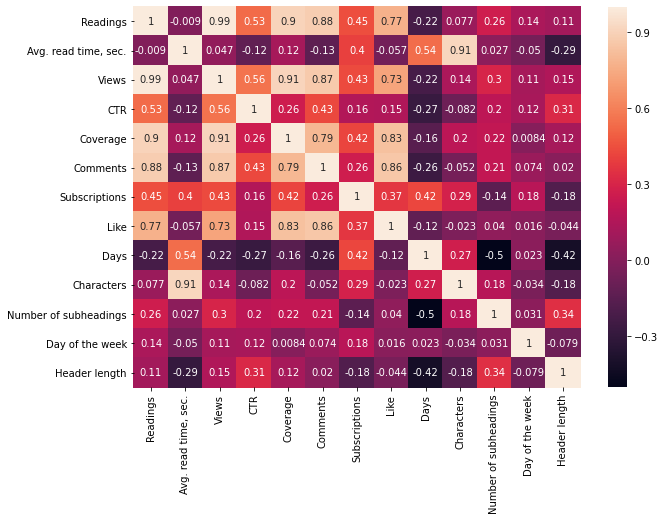

In [32]:
f, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(df_outliner_2019.corr(), annot=True, clip_on=False)

A high correlation with Comments appears here and correlation with Like is growing up.

### Кластеризация

#### Признаки, на которые автор влияет косвенно

In [33]:
df_2019.head()

,Publication,Readings,"Avg. read time, sec.",Views,CTR,Сoverage,Comments,Subscriptions,Like,Days,Characters,Number of subheadings,Day of the week,Header length
Date of publication,,,,,,,,,,,,,,
2019-01-18,Кто отвечает за коммунальные услуги при прямых...,16840,94,19142,2.702356,560511,75,51,457,496,1579,0,4,81
2019-01-31,Минстрой: управляющая организация сама может и...,7499,119,9073,2.852775,157636,38,24,222,483,2023,0,3,66
2019-02-14,Собственникам квартир стали приходить двойные ...,6814,128,8288,3.909767,123281,20,30,236,469,2535,3,3,71
2019-03-06,Верховный суд: магазины не должны убирать трот...,13551,128,15509,4.893862,248638,53,17,233,449,2322,0,2,62
2019-03-09,Право на общее имущество дома сильнее права ар...,17828,139,22229,3.464523,612090,100,111,881,446,2140,1,5,50


In [34]:
df_pr_1 = df_2019[['Readings','Avg. read time, sec.','Comments', 'Subscriptions', 'Like']]

C:\Users\1\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


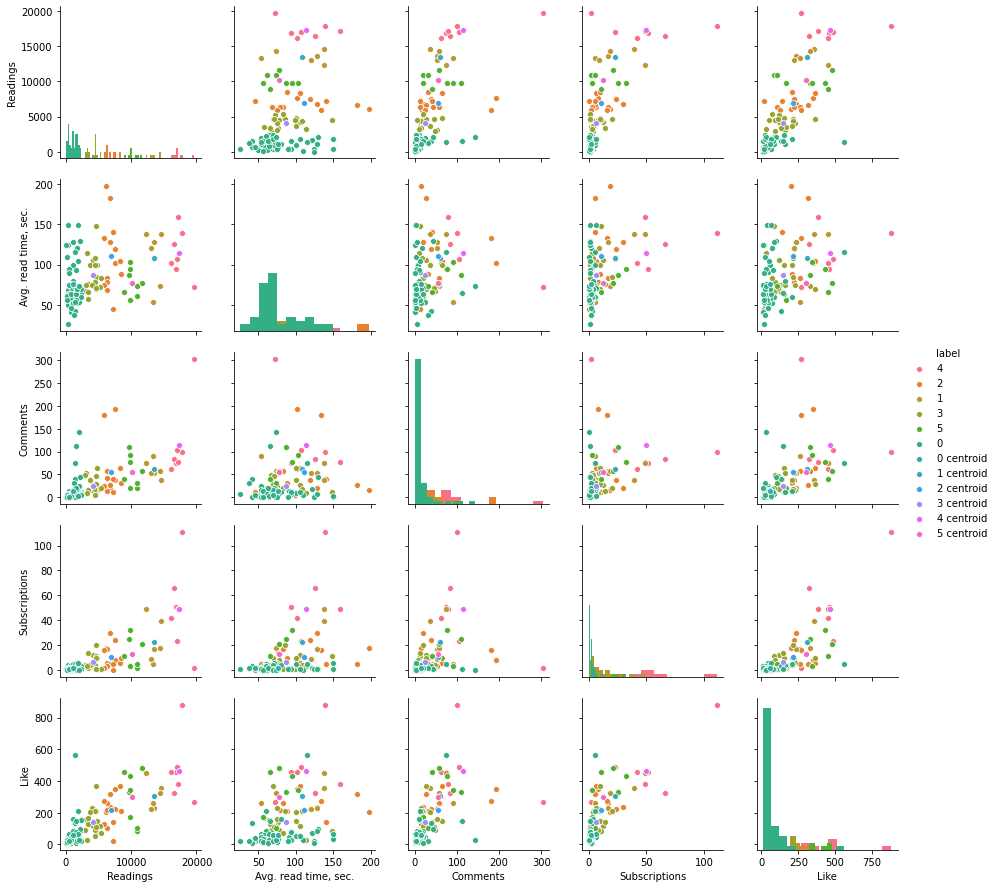

In [35]:
model = KMeans(n_clusters=6, random_state=12345)
model.fit(df_pr_1)
centroids = pd.DataFrame(model.cluster_centers_, columns=df_pr_1.columns)
df_pr_1['label'] = model.labels_.astype(str)
centroids['label'] = ['0 centroid', '1 centroid', '2 centroid', '3 centroid', '4 centroid', '5 centroid']
df_pr_1_all = pd.concat([df_pr_1, centroids], ignore_index=True)
sns.pairplot(df_pr_1_all, hue='label', diag_kind='hist')

In [36]:
df_pr_2 = df_2019[['Readings', 'Characters', 'Number of subheadings', 'Day of the week', 'Header length']]

C:\Users\1\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


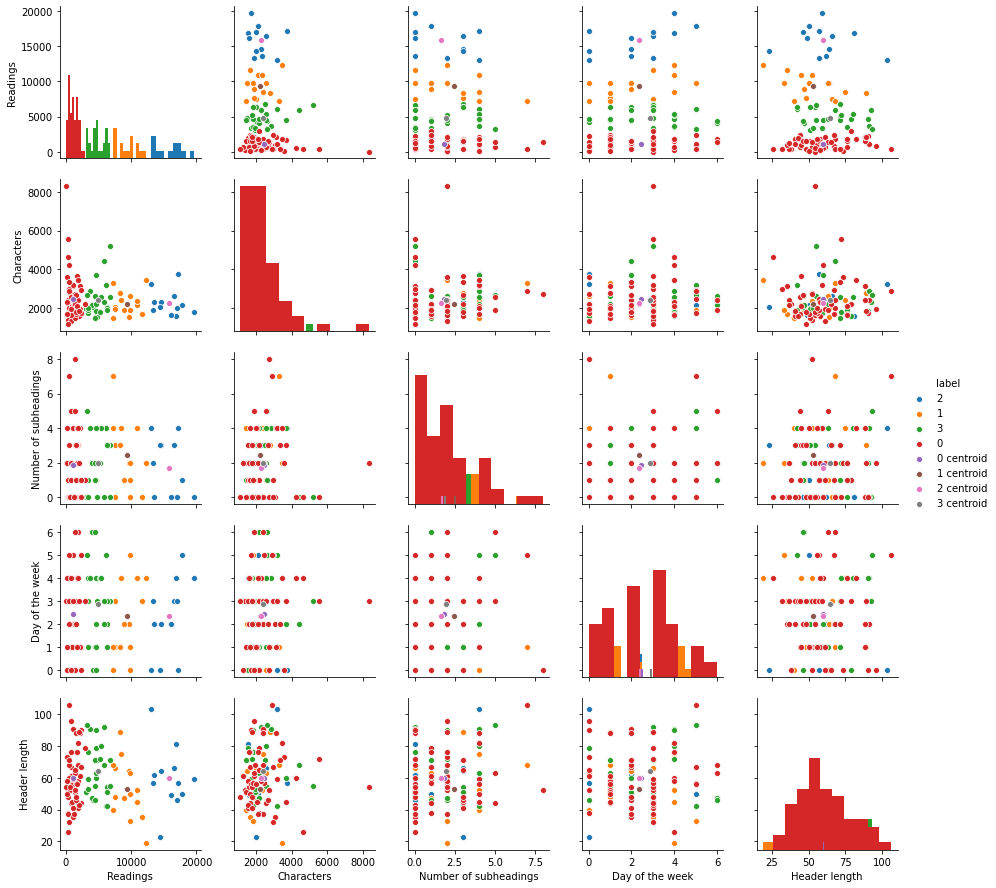

In [37]:
model_2 = KMeans(n_clusters=4, random_state=12345)
model_2.fit(df_pr_2)
df_pr_2.columns
centroids_2 = pd.DataFrame(model_2.cluster_centers_, columns=df_pr_2.columns)
df_pr_2['label'] = model_2.labels_.astype(str)
centroids_2['label'] = ['0 centroid', '1 centroid', '2 centroid', '3 centroid']
df_pr_2_all = pd.concat([df_pr_2, centroids_2], ignore_index=True)
sns.pairplot(df_pr_2_all, hue='label', diag_kind='hist')

Here we see that the maximum in readings is achieved under the following conditions: 1) the number of characters 2000-2100, 2) the subheadings 2, 3) publication on Wednesday, 4) the length of the header is 60 characters.

### Time distribution

Readings in Yandex.Zen statistics is the sum of readings for all days that continue from publication, and not just readings for the day of publication. We saw that according to the data from 2019, the correlation of Readings and Days is weak, therefore this feature of the statistics will not affect our conclusions.

C:\Users\1\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Date readings')

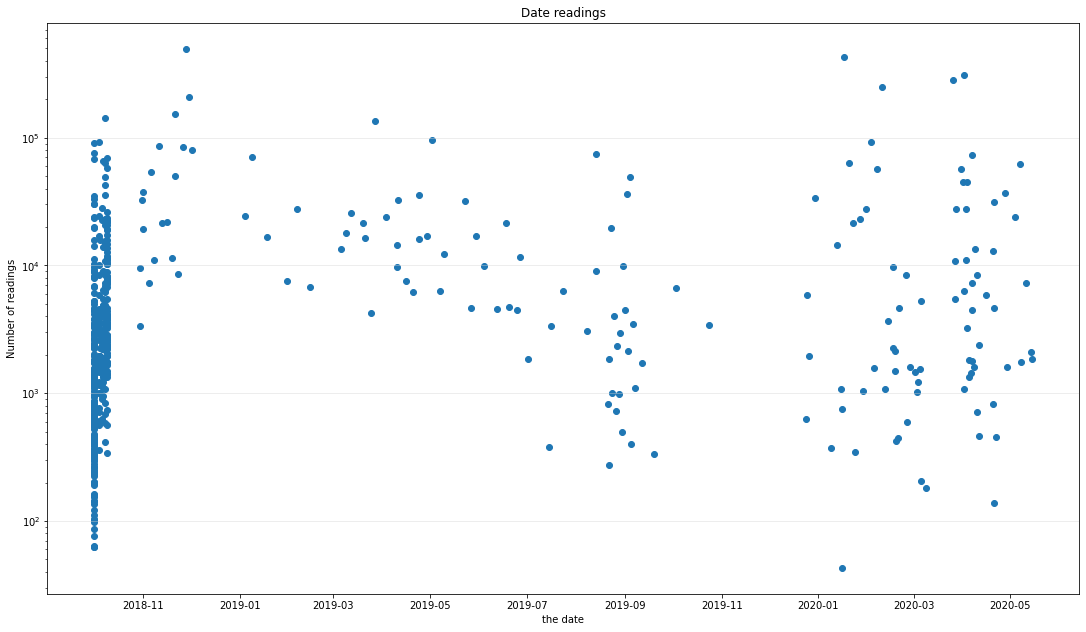

In [38]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.scatter(data.index, data['Readings']) #we take data as it is full data
ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', 
               alpha=0.5)
plt.xlabel('the date')
plt.ylabel('Number of readings')
plt.yscale('log')
plt.title('Date readings')

Here you can see that in October 2018 all the records for the year were collected, since Yandex.Zen has an error with displaying statistics of the records that were edited. It can be seen that the recording density in January-May 2020 is higher than the recording density for the entire 2019. In addition, since July 2019, many articles began to gain less than the 10 ^ 3 line. The general decline trend is evident during 2019.

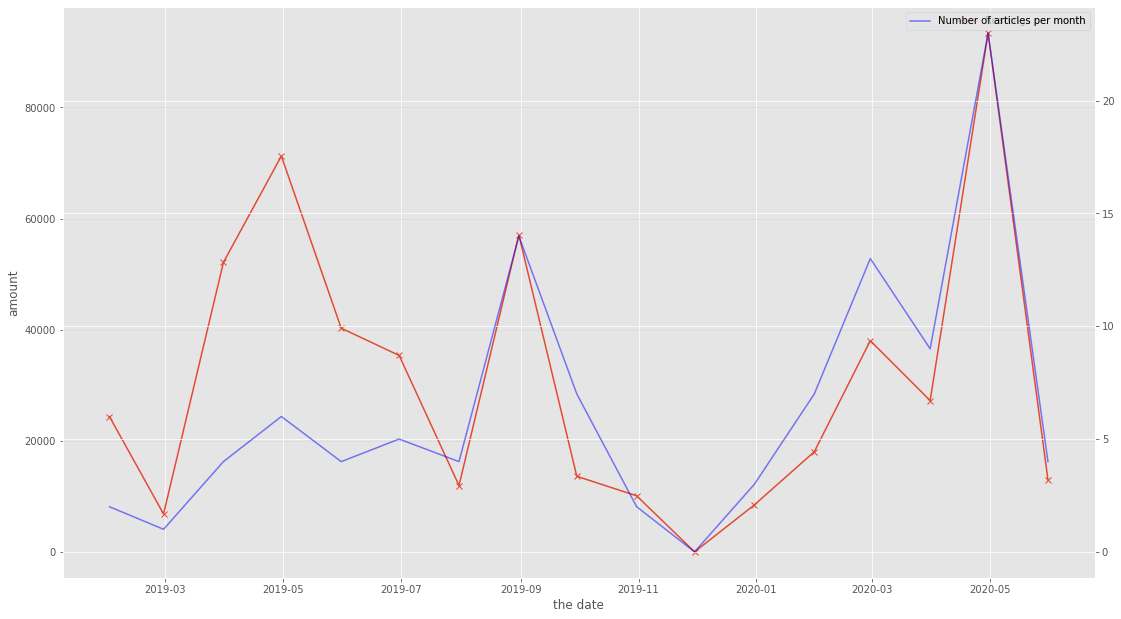

In [39]:
df_2019_average = df_2019.resample('M').sum()
dg = df_2019['Readings'].resample('M').count()
plt.style.use('ggplot')

fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.plot(df_2019_average['Readings'], marker='x', label='Readings per month')
plt.xlabel('the date')
plt.ylabel('amount')
plt.legend()
ax2 = ax.twinx()
ax2.plot(dg, c='b', alpha=0.5, label='Number of articles per month')
ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', 
               alpha=0.5)
plt.legend()
plt.show()

Here we see that the movement of the Reading line (by month) and the line of the number of articles (by month) coincides. The more you write, the more readings you get.

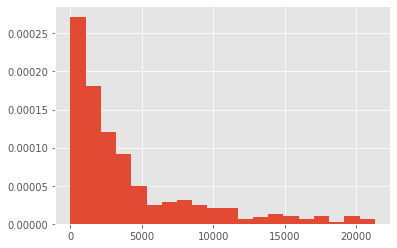

In [40]:
data['Readings'].hist(bins=20, range=(0, 21323), density=True) 

In [41]:
def ecdf(data): 
    n = len(data)
    # x-data for the ECDF: x
    x = np.sort(data)
    # y-data for the ECDF: y
    y = np.arange(1, len(x)+1) / n
    return x, y

Text(0, 0.5, 'CDF')

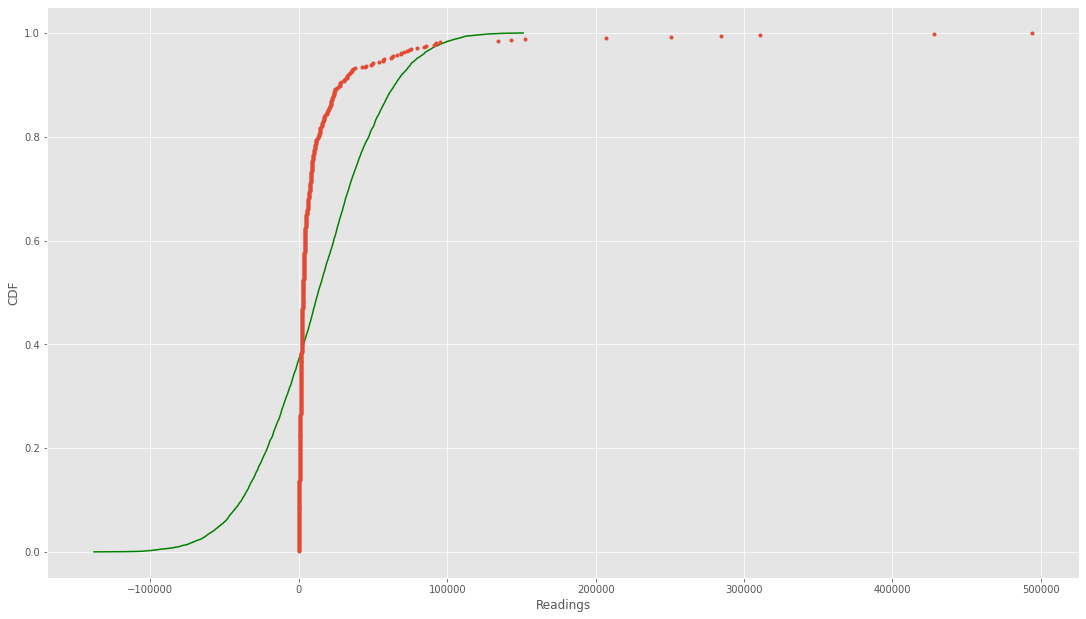

In [42]:
mu = data['Readings'].mean() #check that our distribution is normal
sigma = data['Readings'].std()
samples = np.random.normal(mu, sigma, size=10000)
x_theor, y_theor = ecdf(samples)
x, y = ecdf(data['Readings'])
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
plt.plot(x_theor, y_theor, c='g')
plt.plot(x, y, marker='.', linestyle='none')
plt.xlabel('Readings')
plt.ylabel('CDF')

Our distribution is not normal.

Text(0, 0.5, 'CDF')

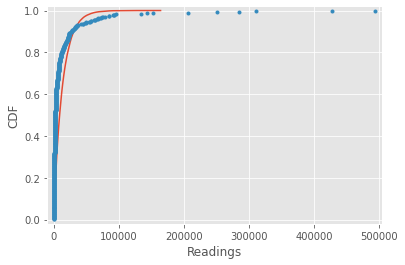

In [43]:
x_exp, y_exp = ecdf(data['Readings'])
inter = np.random.exponential(data['Readings'].mean(), 100000) 
x_theor_exp, y_theor_exp = ecdf(inter)
plt.plot(x_theor_exp, y_theor_exp) 
plt.plot(x_exp, y_exp, marker='.', linestyle='none')
plt.margins(0.02)
plt.xlabel('Readings')
plt.ylabel('CDF')

But it corresponds to an exponential distribution.

1754.9319421557498
1737.9923249460985


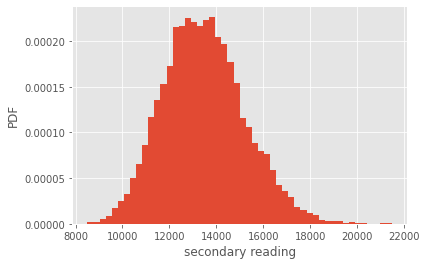

In [44]:
def bootstrap_replicate_1d(dt, func):
    bs_sample = np.random.choice(dt, len(dt))
    return func(bs_sample)
def draw_bs_reps(dt, func, size=10000):
    bs_replicates = np.empty(10000)
    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(dt, func)
    return bs_replicates
bs_replicates = draw_bs_reps(data['Readings'], np.mean, size=10000)
sem = np.std(data['Readings']) / np.sqrt(len(data['Readings'])) #standard error of the mean
bs_std = np.std(bs_replicates)
print(sem)
print(bs_std)

_ = plt.hist(bs_replicates, bins=50, density=True)
_ = plt.xlabel('secondary reading')
_ = plt.ylabel('PDF')

The density distribution of the probability of the average readings obtained using the bootstrap is shown here. Below I test following idea. Since December 2019, I began to change the channel: there were more extraneous materials, the topic expanded. The null hypothesis: the average for the period from January to December 2019 and the average from December 2019 to May 2020 are equal at the significance level.

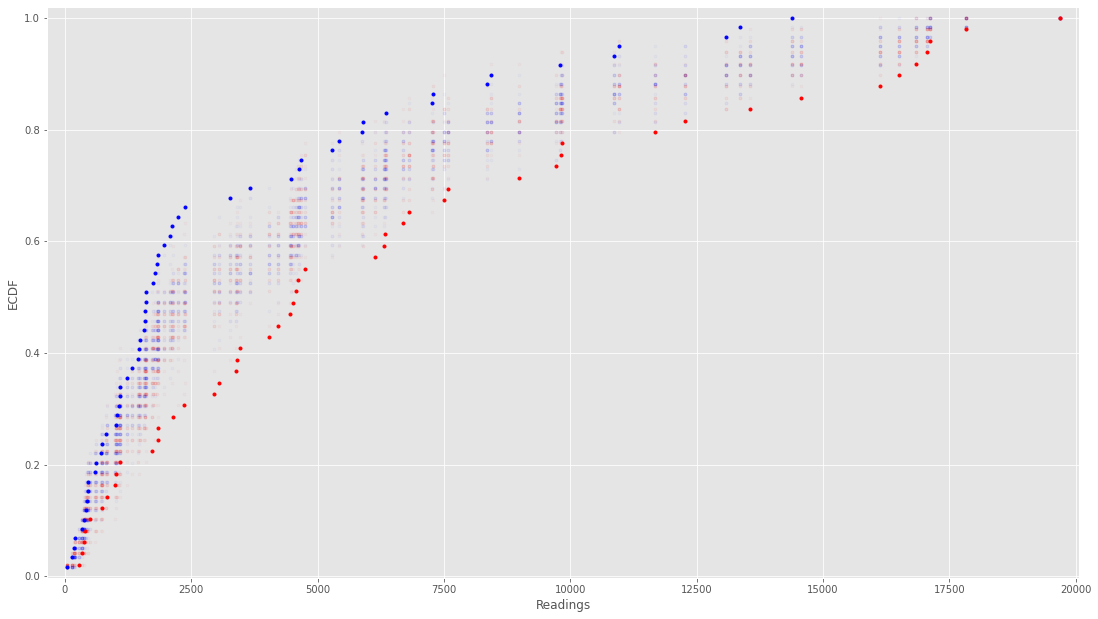

In [45]:
df_j = df_2019.loc['2019-01-01':'2019-11-30', 'Readings']
df_d = df_2019.loc['2019-12-01':'2020-05-18', 'Readings']
def permutation_sample(data1, data2): #permutation test
    data = np.concatenate((data1, data2))
    permuted_data = np.random.permutation(data)
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]
    return perm_sample_1, perm_sample_2
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
for _ in range(50):
    perm_sample_1, perm_sample_2 = permutation_sample(
                                    df_j, df_d)

    x_1, y_1 = ecdf(perm_sample_1)
    x_2, y_2 = ecdf(perm_sample_2)

    
    _ = plt.plot(x_1, y_1, marker='.', linestyle='none',
                 color='red', alpha=0.02)
    _ = plt.plot(x_2, y_2, marker='.', linestyle='none',
                 color='blue', alpha=0.02)


x_1, y_1 = ecdf(df_j)
x_2, y_2 = ecdf(df_d)
_ = plt.plot(x_1, y_1, marker='.', linestyle='none', color='red')
_ = plt.plot(x_2, y_2, marker='.', linestyle='none', color='blue')


plt.margins(0.02)
_ = plt.xlabel('Readings')
_ = plt.ylabel('ECDF')
plt.show()

The distribution of the two periods varies significantly.

Findings:
1) Significant signs for Reading are Coverages and Views. These are signs that the author cannot influence. The only sign that the author can indirectly influence is Like. In addition, the total number of readings per month depends on the number of articles per month.
2) Statistics Yandex.Zen does not allow you to plan activities for the development of the channel. The readings are distributed exponentially.
3) An additional conclusion is that the statistics contain errors. So, for example, the dates of publication of entries change each time you edit an entry.